Author: Hsuan-lin Her
Created: 12-06-2018
Last Modified: 12-06-2018

Purpose: To calculate 
- Sequence identity within clusters in network
- Domain identity (pfam) within clusters
- nr annotation consistency
- CARD consistency
- COG consistency

Input: networks (LLS > threshold) file at ~/data0118/network1122

Annotations:
- pfam: ~/data0118/cdhit/pfam/df/Escherichia0.70
- nr: ~/data0118/network1122/ecoli70_simple.xlsx

In [1]:
# identify clusters
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# load from edge list
path = '/home/hermuba/data0118/network1122/'
def edge_list(fname):
    
    file = path + fname
    edge = pd.read_csv(file)
    edge[['gene_one', 'gene_two', 'goldstandard']].to_csv(path + fname + '_edgelist', index = False, header = False, na_rep = 'nan')
def to_net(fname):
    # generate edge_list
    edge_list(fname)
    
    net = nx.read_edgelist(path + fname + '_edgelist', delimiter = ',', nodetype = str, data=(('goldstandard',str),))
    return(net)


In [3]:
file_e = 'refseq_mu_high_75.csv'
net = to_net(file_e)

In [4]:
# playing with the net
net.number_of_nodes()

13234

In [5]:
net.number_of_edges()

113811

In [6]:
# nodes adjacent to node '562.23416.con.0004_267|562.23416'
#for i in net.neighbors('562.23416.con.0004_267|562.23416'):
#    print(i)

In [7]:
# analyzing them: connected components = all connected nodes in one component
clus = nx.connected_components(net)
# save to list
subcluster_list = list(clus)
# to show 1 subcluster
subcluster_list[7]

{'562.22741.con.0052_21|562.22741', '562.23635.con.0049_2|562.23635'}

In [8]:
# inputting pfam information
pfam_df = pd.read_pickle('/home/hermuba/data0118/cdhit/pfam/df/Escherichia0.70')
pfam_df.head()

,seq id,alignment start,alignment end,envelope start,envelope end,hmm acc,hmm name,type,hmm start,hmm end,hmm length,bit score,E-value,significance,clan
0,JMUY01000001_3|1438670.3,39,177,39,177,PF02413.16,Caudo_TAP,Family,1,130,130,127.3,4.000000e-37,1,CL0348
1,JMUY01000001_5|1438670.3,6,153,4,154,PF12571.7,DUF3751,Family,3,149,150,179.2,4.600000e-53,1,No_clan
2,JMUY01000001_5|1438670.3,173,213,173,214,PF03406.12,Phage_fiber_2,Repeat,1,41,42,69.6,1.100000e-19,1,No_clan
3,JMUY01000001_5|1438670.3,217,257,217,258,PF03406.12,Phage_fiber_2,Repeat,1,41,42,70.4,6.200000e-20,1,No_clan
4,JMUY01000001_5|1438670.3,261,300,261,302,PF03406.12,Phage_fiber_2,Repeat,1,40,42,63.2,1.100000e-17,1,No_clan


In [9]:
pfam_df.shape

(24386, 15)

In [10]:
# each protein may have more than one pfam result, representing multiple domain protein. We aggregate it with ','
domain_list = pfam_df.groupby(by = 'seq id')['hmm name'].agg(','.join)

In [11]:
def global_domain_similarity(subgraph):
    all_exist_dm = set()
    intersect_dm = set()
    no_pfam = []
    for node in subgraph:
        if node in domain_list.index:
            node_domain = set(domain_list[node].split(','))
            all_exist_dm = all_exist_dm.union(node_domain)
            intersect_dm = intersect_dm.intersection(node_domain)
        else: 
            no_pfam.append(node)
    return(len(all_exist_dm), len(intersect_dm), len(no_pfam), len(subgraph))
        

In [12]:
# clus_char returns No. of all domains in one cluster; common_domains in one cluster; number of nodes without pfam information; the size of the cluster (how many nodes)
clus_char = pd.DataFrame(columns = ['all_domain', 'common_domain', 'no_pfam', 'cluster_size'])
i = 0
for s in subcluster_list:
    all_dm, common_df, no_pfam, clus_size = global_domain_similarity(s)
    clus_char.loc[i]= [all_dm, common_df, no_pfam, clus_size]
    i += 1

In [13]:
clus_char.head()

,all_domain,common_domain,no_pfam,cluster_size
0,12,0,31,84
1,8,0,68,90
2,9,0,59,68
3,2,0,8,93
4,0,0,4,4


In [14]:
# how many clusters in that network
clus_char.shape

(2820, 4)

In [15]:
# largest cluster
clus_char['cluster_size'].max()

1374

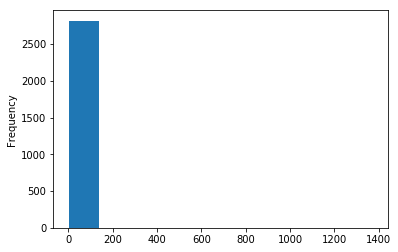

In [16]:
# distribution of cluster size
clus_char['cluster_size'].plot(kind = 'hist')

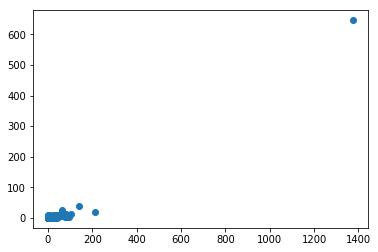

In [17]:
plt.scatter(clus_char['cluster_size'], clus_char['all_domain'])

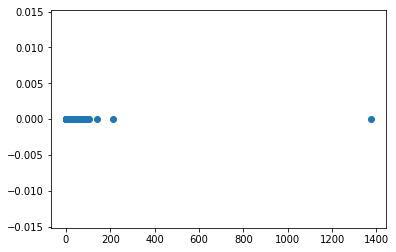

In [18]:
plt.scatter(clus_char['cluster_size'], clus_char['common_domain'])
# no cluster with all the same domain components

In [19]:
# local domain cosistency
def edges(fname):
    path = '/home/hermuba/data0118/network1122/'    
    file = path + fname
    edge = pd.read_csv(file)
    return(edge)
e = edges(file_e)

In [20]:
e.shape

(113811, 5)

In [21]:
e.head()

,mutual_info,nrm_mutual,gene_one,gene_two,goldstandard
0,0.419584,0.787639,562.23304.con.0006_192|562.23304,562.22658.con.0002_220|562.22658,NaN
1,0.391253,0.773301,562.23304.con.0006_192|562.23304,562.22909.con.0002_319|562.22909,NaN
2,0.074130,0.919936,562.22859.con.0026_36|562.22859,562.22697.con.0023_36|562.22697,NaN
3,0.409849,0.815928,562.23304.con.0006_192|562.23304,562.23416.con.0004_246|562.23416,NaN
4,0.077508,0.871718,562.22859.con.0026_36|562.22859,562.22859.con.0026_30|562.22859,NaN


In [22]:
def local_domain_similarity(p1, p2):
    if p1 in domain_list.index and p2 in domain_list:
        
        pd1 = set(domain_list[p1].split(','))
        pd2 = set(domain_list[p2].split(','))
        
        return(len(pd1.intersection(pd2)), len(pd1.union(pd2)))
    else: 
        return('nan', 'nan')

In [23]:
# testing
print(domain_list['562.23260.con.0008_59|562.23260'],domain_list['562.23583.con.0046_4|562.23583'],local_domain_similarity('562.23260.con.0008_59|562.23260', '562.23583.con.0046_4|562.23583'))

Ead_Ea22 Ead_Ea22 (1, 1)


In [24]:
local_domain_similarity('562.23304.con.0006_192|562.23304', '562.22658.con.0002_220|562.22658')

('nan', 'nan')

In [25]:
e['all_domain'] = ''
e['common_domain'] = ''

for index, row in e.iterrows():
    common, all_domain = local_domain_similarity(row['gene_one'], row['gene_two'])
    if all_domain != 'nan':
        e.loc[index, ['all_domain', 'common_domain']] = [all_domain, common]

In [26]:
not_empty_e = e.loc[e['all_domain'] != '']

In [27]:
percent_shared = not_empty_e['common_domain']/not_empty_e['all_domain']

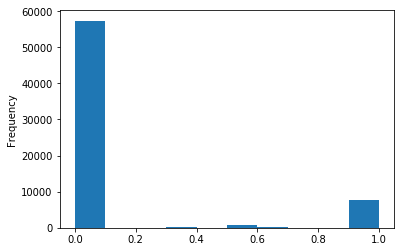

In [28]:
percent_shared.plot(kind = 'hist') # most do not share domains ya-ay

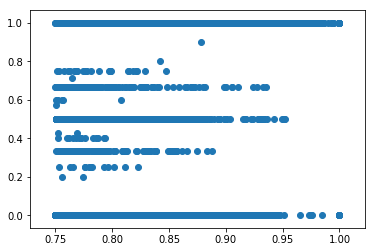

In [29]:
plt.scatter(not_empty_e['nrm_mutual'], percent_shared) # the level of mutual information is independent to domain sharing

In [30]:
seq_iden = pd.read_pickle('/home/hermuba/data0118/cdhit/blast_two/EC70_self_df')
seq_iden.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,JMUY01000001_1|1438670.3,JMUY01000001_1|1438670.3,100.0,43,0,0,1,43,1,43,3.200000e-17,83.2
1,JMUY01000001_3|1438670.3,JMUY01000001_3|1438670.3,100.0,178,0,0,1,178,1,178,2.100000e-99,358.2
2,JMUY01000001_3|1438670.3,JMUY01000001_572|1438670.3,69.7,178,54,0,1,178,1,178,1.800000e-69,258.8
3,JMUY01000001_3|1438670.3,562.23660.con.0023_22|562.23660,54.2,190,73,2,1,178,2,189,8.200000e-51,196.8
4,JMUY01000001_3|1438670.3,562.23709.con.0004_192|562.23709,48.8,168,80,1,1,168,1,162,1.400000e-42,169.5


In [31]:
e.head()

,mutual_info,nrm_mutual,gene_one,gene_two,goldstandard,all_domain,common_domain
0,0.419584,0.787639,562.23304.con.0006_192|562.23304,562.22658.con.0002_220|562.22658,NaN,,
1,0.391253,0.773301,562.23304.con.0006_192|562.23304,562.22909.con.0002_319|562.22909,NaN,,
2,0.074130,0.919936,562.22859.con.0026_36|562.22859,562.22697.con.0023_36|562.22697,NaN,,
3,0.409849,0.815928,562.23304.con.0006_192|562.23304,562.23416.con.0004_246|562.23416,NaN,,
4,0.077508,0.871718,562.22859.con.0026_36|562.22859,562.22859.con.0026_30|562.22859,NaN,,


In [32]:
new_df = pd.merge(e, seq_iden,  how='inner', left_on=['gene_one','gene_two'], right_on = ['qseqid','sseqid'])

In [33]:
new_df.head()

,mutual_info,nrm_mutual,gene_one,gene_two,goldstandard,all_domain,common_domain,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,0.012270,0.877352,562.23935.con.0006_1|562.23935,562.23781.con.0198_1|562.23781,NaN,,,562.23935.con.0006_1|562.23935,562.23781.con.0198_1|562.23781,90.0,20,2,0,22,41,34,53,6.000000e-05,42.4
1,0.079719,0.965408,562.22859.con.0026_36|562.22859,562.22477.con.0024_24|562.22477,NaN,,,562.22859.con.0026_36|562.22859,562.22477.con.0024_24|562.22477,67.4,43,14,0,9,51,10,52,9.700000e-10,59.3
2,0.142044,0.926829,562.22661.con.0008_31|562.22661,562.23589.con.0042_6|562.23589,NaN,,,562.22661.con.0008_31|562.22661,562.23589.con.0042_6|562.23589,72.5,51,14,0,1,51,13,63,1.400000e-16,81.6
3,0.058916,0.862452,562.23288.con.0012_1|562.23288,562.23165.con.0020_1|562.23165,NaN,,,562.23288.con.0012_1|562.23288,562.23165.con.0020_1|562.23165,100.0,17,0,0,2,18,1,17,4.400000e-04,39.7
4,0.002872,0.767374,562.23635.con.0049_2|562.23635,562.22741.con.0052_21|562.22741,NaN,,,562.23635.con.0049_2|562.23635,562.22741.con.0052_21|562.22741,63.2,117,42,1,1,116,1,117,1.200000e-37,152.5


In [34]:
new_df.shape

(13644, 19)

In [36]:
new_df['pident'].describe() # high sequence identity mean = 60%

count    13644.000000
mean        59.344173
std         17.774844
min         19.700000
25%         46.300000
50%         57.200000
75%         68.700000
max        100.000000
Name: pident, dtype: float64

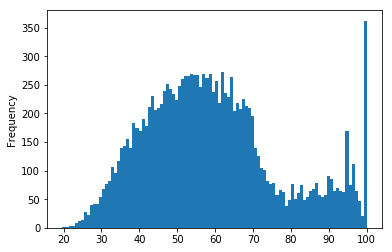

In [37]:
new_df['pident'].plot(kind = 'hist', bins = 100)

/home/hermuba/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


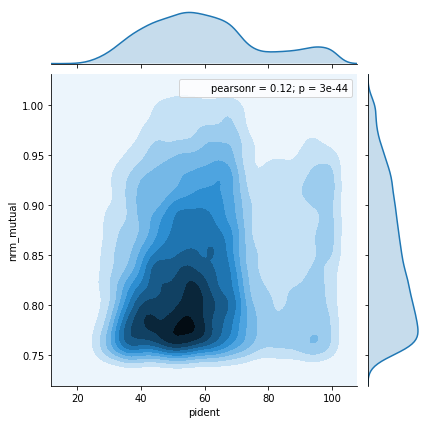

In [38]:
import seaborn as sns
sns.jointplot(new_df['pident'], new_df['nrm_mutual'], kind = 'kde')

# Degree distribution

In [42]:
# degree distribution
degree_sequence = [d for n, d in net.degree()]

import numpy as np
degree_sequence = np.asarray(degree_sequence)

hist, bins = np.histogram(degree_sequence, bins = 50)

In [64]:
np.max(degree_sequence)

494

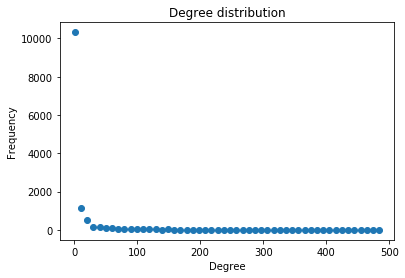

In [53]:
import matplotlib.pyplot as plt
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.scatter(bins[:-1], hist)

Text(3, 3, 'r=-1.3571057409721665')

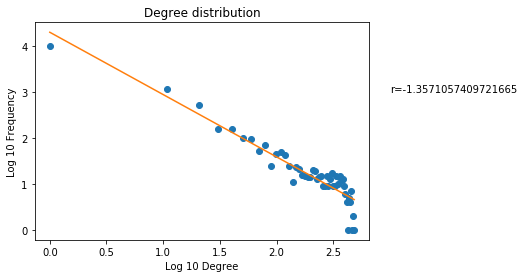

In [63]:
from scipy import stats
logx = np.log10(bins[:-1])
logy = np.log10(hist)

slope, intercept, r_value, p_value, std_err = stats.linregress(logx, logy)
line = slope*logx+ intercept


plt.title('Degree distribution')
plt.xlabel('Log 10 Degree')
plt.ylabel('Log 10 Frequency')
plt.plot(logx, logy, 'o',logx, line)
plt.text(3,3,'r='+str(slope))

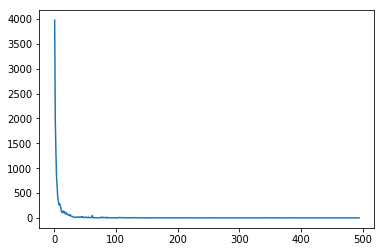

In [58]:
from collections import Counter
c = Counter(degree_sequence)
sorted(c.items())
plt.plot(*zip(*sorted(c.items())))